In [1]:
import astropy.units as u
import astropy.constants as const
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib

In [2]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

pd.set_option('display.max_columns', None)

# 12.2

In [3]:
masses = [0.3, 3, 30] * u.Msun

## part a

In [4]:
def R_Hayashi_start(M):
    return 100 * u.Rsun * M.to(u.Msun).value

def R_Hayashi_end(M):
    return 2 * u.Rsun * M.to(u.Msun).value

def R_PMS_start(M):
    return R_Hayashi_end(M)

def R_PMS_end(M):
    return u.Rsun * M.to(u.Msun).value**(0.7)

In [5]:
for mass in masses:
    print(R_Hayashi_start(mass).value, R_Hayashi_end(mass).value, R_PMS_start(mass).value, np.round(R_PMS_end(mass).value, 2))

30.0 0.6 0.6 0.43
300.0 6.0 6.0 2.16
3000.0 60.0 60.0 10.81


## part b

In [6]:
def tau_Hayashi(M):
    return 1e6 * u.yr / M.to(u.Msun).value

def tau_PMS(M):
    return 6e7 * u.yr * M.to(u.Msun).value**(-2.5)

In [7]:
for mass in masses:
    print(f"Mass: {mass}\t Hayashi: {tau_Hayashi(mass):1.2e} | PMS: {tau_PMS(mass):1.2e}")

Mass: 0.3 solMass	 Hayashi: 3.33e+06 yr | PMS: 1.22e+09 yr
Mass: 3.0 solMass	 Hayashi: 3.33e+05 yr | PMS: 3.85e+06 yr
Mass: 30.0 solMass	 Hayashi: 3.33e+04 yr | PMS: 1.22e+04 yr


# 15.4

First we can get the data rather than copy out of the textbook

In [8]:
def radiation_driven_mass_loss(L, T_eff, M, R):
    v_esc = np.sqrt(2 * const.G * M / R)
    if T_eff >= 21000 * u.K:
        v_inf = 2.6 * v_esc
    elif 10000 * u.K <= T_eff <= 20000 * u.K:
        v_inf = 1.3 * v_esc
    elif T_eff >= 8000 * u.K:
        v_inf = 0.7 * v_esc
    else:
        return 0 * u.Msun / u.yr

    return (L / (v_inf * const.c)).to(u.Msun / u.yr)

In [9]:
masses = [0.8, 0.9, 1, 2, 3, 4, 5, 7, 9, 12, 15, 20, 25, 32, 40, 60, 85, 120]
Zs = ["14", "02"]

In [10]:
READ = False
if READ:
    for Z in Zs:
        for mass in masses:
            mass_str = f"{mass:03}".replace(".", "p")
            url = f"https://obswww.unige.ch/Recherche/evol/tables_grids2011/Z0{Z}/M{mass_str}Z{Z}V0.dat"
            response = urllib.request.urlopen(url)
            with open(f"data/Z_0.0{Z}/m_{mass}.dat", "w") as file:
                file.write(response.read().decode())

In [11]:
def vink_mass_loss(L, T_eff, M, Z):
    """Calculate the mass loss rate using the Vink et al. (2001) fits (see Eq. 15.14 in the textbook). The constants
    comes from Table 15.3.

    Parameters
    ----------
    L : `float/array`
        Luminosity
    T_eff : `float/array`
        Effective Temperature
    M : `float/array`
        Mass
    Z : `float/array`
        Metallicity

    Returns
    -------
    mlr : `float/array`
        Mass Loss Rate
    """
    if T_eff < 12500 * u.K or L < 3e4 * u.Lsun:
        return 0
    elif T_eff <= 25000 * u.K:
        A = -6.688
        B = 2.210
        C = -1.339
        D = -1.601
        T_ref = 20000 * u.K
        E = 1.07
        F = 0
        G = 0.85
        v_inf_over_v_esc = 1.3
    else:
        A = -6.697
        B = 2.194
        C = -1.313
        D = -1.226
        T_ref = 40000 * u.K
        E = 0.933
        F = -10.92
        G = 0.85
        v_inf_over_v_esc = 2.6

    if T_eff > 50000 * u.K:
        print(f"WARNING: too hot (M = {M:1.2e}, Z = {Z})")
    
    log_m_dot = A \
        + B * np.log10(L / (1e5 * u.Lsun))\
        + C * np.log10(M / (30 * u.Msun))\
        + D * np.log10(0.5 * v_inf_over_v_esc)\
        + E * np.log10(T_eff / T_ref)\
        + F * (np.log10(T_eff / T_ref))**2\
        + G * np.log10(Z / 0.02)
    
    return 10**(log_m_dot) * u.Msun / u.yr

In [12]:
def get_m_dot(df, line=1, Z=0.014):
    L = 10**(df.loc[line]["lg(L)"]) * u.Lsun
    T_eff = 10**(df.loc[line]["lg(Teff)"]) * u.K
    M = df.loc[line]["mass"] * u.Msun
    
    real_m_dot = 10**(df.loc[line]['lg(Md)']) * u.Msun / u.yr
    if real_m_dot.value == 1.0:
        real_m_dot = 0.0 * u.Msun / u.yr

    return vink_mass_loss(L=L, T_eff=T_eff, M=M, Z=Z), real_m_dot

def get_t_MS(df):
    return (df.loc[109]["time"] - df.loc[1]["time"]) * u.yr

def get_mfl(df):
    return (df.loc[1]["mass"] - df.loc[109]["mass"]) / df.loc[1]["mass"]

In [13]:
real_mass_loss_rates = np.zeros((len(Zs), len(masses), 2)) * u.Msun / u.yr
mass_loss_rates = np.zeros((len(Zs), len(masses), 2)) * u.Msun / u.yr
t_MS = np.zeros((len(Zs), len(masses))) * u.yr
real_mfl = np.zeros((len(Zs), len(masses)))

for i, Z in enumerate(Zs):
    for j, mass in enumerate(masses):
        df = pd.read_csv(f"data/Z_0.0{Z}/m_{mass}.dat", delim_whitespace=True, header=0, skiprows=[1])
        df.set_index("line", inplace=True)
        
        # print(f"Mass: {mass}, Z: {Z}")
        t_MS[i, j] = get_t_MS(df)
        real_mfl[i, j] = get_mfl(df)
        
        for k, line in enumerate([1, 109]):
            calc, real = get_m_dot(df, line=line, Z=float("0.0" + Z))
            mass_loss_rates[i, j, k] = calc
            real_mass_loss_rates[i, j, k] = real
            # print(f"\t{upper.value:1.2e} {real.value:1.2e}", upper >= real)

avg_real_mlr = real_mass_loss_rates.mean(axis=2)
avg_calc_mlr = mass_loss_rates.mean(axis=2)

## Part a Answers

#### ZAMS Mass loss rates

Z = 0.014

In [14]:
mass_loss_rates[0, :, 0]

<Quantity [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.22015197e-08,
           6.71865882e-08, 1.92417555e-07, 4.36978800e-07, 1.50665919e-06,
           3.61077842e-06, 7.65785381e-06] solMass / yr>

Z = 0.002

In [15]:
mass_loss_rates[1, :, 0]

<Quantity [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.99937732e-09,
           1.38114365e-08, 3.66996185e-08, 7.90449304e-08, 2.52573688e-07,
           5.72994683e-07, 1.15356643e-06] solMass / yr>

#### TAMS Mass loss rates

Z = 0.014

In [16]:
mass_loss_rates[0, :, 1]

<Quantity [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
           0.00000000e+00, 0.00000000e+00, 1.15030251e-08, 6.56089989e-08,
           1.78079337e-07, 3.99869445e-07, 5.92924028e-07, 2.23773137e-05,
           3.85513200e-06, 9.04640046e-05] solMass / yr>

Z = 0.002

In [17]:
mass_loss_rates[1, :, 1]

<Quantity [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
           0.00000000e+00, 0.00000000e+00, 4.68046324e-09, 2.30935230e-08,
           6.53482861e-08, 1.69750379e-07, 3.42158626e-07, 8.74714031e-07,
           1.24581804e-06, 1.38411220e-05] solMass / yr>

## Part b

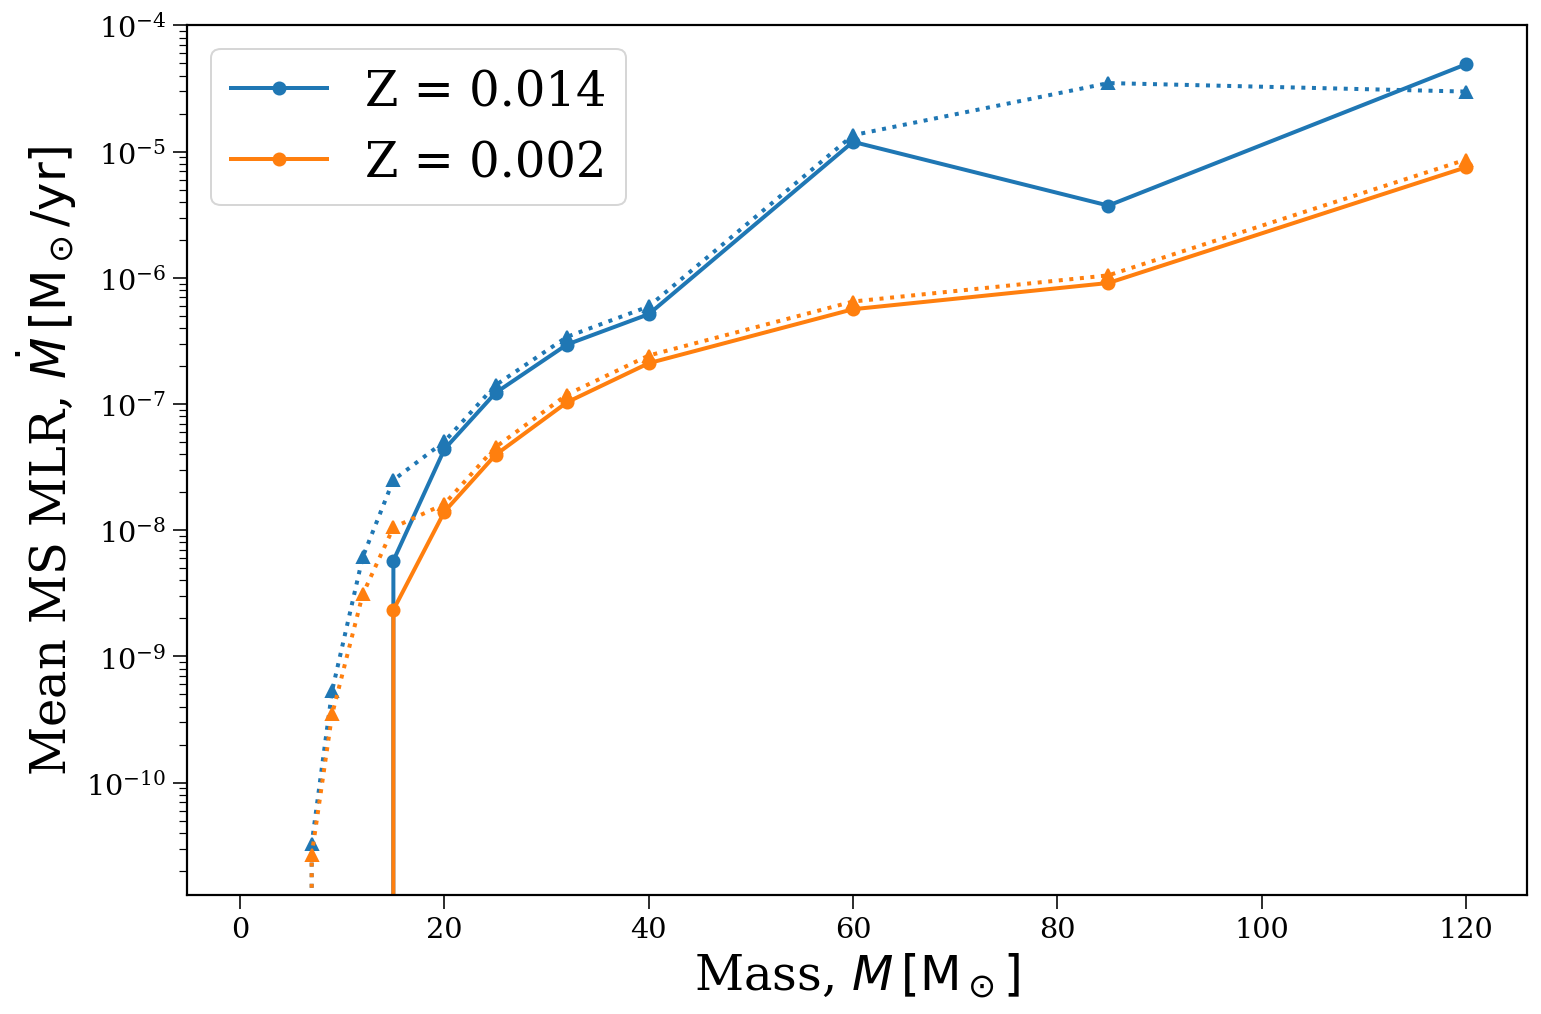

In [18]:
colours = ["tab:blue", "tab:orange"]
labels = ["Z = 0.014", "Z = 0.002"]

fig, ax = plt.subplots()

for real, calc, colour, label in zip(avg_real_mlr, avg_calc_mlr, colours, labels):
    ax.plot(masses, real, linestyle="dotted", color=colour, lw=2, marker="^")
    ax.plot(masses, calc, color=colour, label=label, lw=2, marker="o")
    
ax.legend()

ax.set_xlabel(r"Mass, $M \, [\rm M_\odot]$")
ax.set_ylabel(r"Mean MS MLR, $\dot{M} \, [\rm M_\odot / yr]$")

ax.set_yscale("log")

plt.savefig("figures/mean_MS_mlr.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [19]:
calc_mfl = avg_calc_mlr * t_MS / (masses * u.Msun)

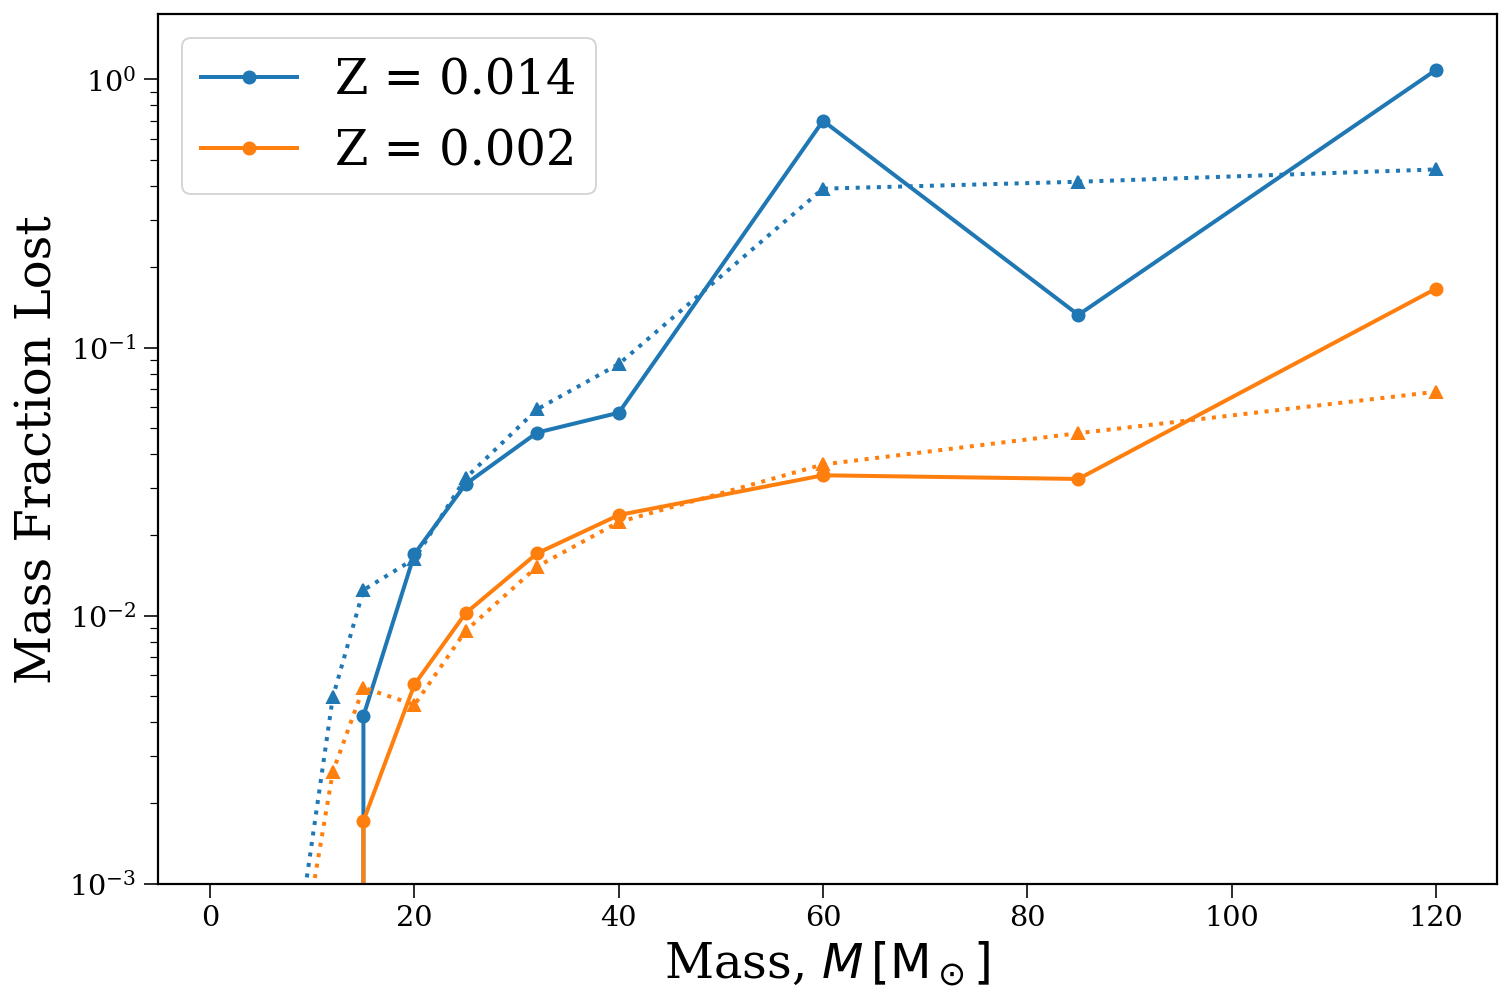

In [20]:
colours = ["tab:blue", "tab:orange"]
labels = ["Z = 0.014", "Z = 0.002"]

fig, ax = plt.subplots()

for real, calc, colour, label in zip(real_mfl, calc_mfl, colours, labels):
    ax.plot(masses, real, linestyle="dotted", color=colour, lw=2, marker="^")
    ax.plot(masses, calc, color=colour, label=label, lw=2, marker="o")
    
ax.legend()

ax.set_xlabel(r"Mass, $M \, [\rm M_\odot]$")
ax.set_ylabel("Mass Fraction Lost")

ax.set_yscale("log")
ax.set_ylim(bottom=1e-3)

plt.savefig("figures/mass_fraction_lost.pdf", format="pdf", bbox_inches="tight")

plt.show()

# 16.1

In [21]:
def get_R(L, T_eff):
    return np.sqrt(L / (4 * np.pi * const.sigma_sb * T_eff**4)).to(u.Rsun)

log_Ls = [0.4, 3.4]
log_T_effs = [3.7, 3.48]
labels = ["Start of RGB", "  End of RGB"]

for log_L, log_T_eff, label in zip(log_Ls, log_T_effs, labels):
    print(f"Radius at {label}: {get_R(L=10**(log_L) * u.Lsun, T_eff=10**(log_T_eff) * u.K):1.1f}")

Radius at Start of RGB: 2.1 solRad
Radius at   End of RGB: 183.1 solRad


# 17.1

In [22]:
def uniform_sphere_GPE(M, rho):
    return - (const.G / 5 * (36 * np.pi * M**5 * rho)**(1/3)).to(u.erg)

In [23]:
delta_u = uniform_sphere_GPE(0.5 * u.Msun, 1e4 * u.g / u.cm**3) - uniform_sphere_GPE(0.5 * u.Msun, 1e6 * u.g / u.cm**3)

In [24]:
(delta_u / (0.2e10 * u.Lsun)).to(u.yr).round(2)

<Quantity 0.21 yr>

In [25]:
(delta_u / (0.2e10 * u.Lsun)).to(u.day).round(0)

<Quantity 76. d>